# Data Processor and Packager for im2latex Data

This project contains 2 data sources for initial training:
- [im2latex-100k](https://huggingface.co/datasets/yuntian-deng/im2latex-100k) located at `./data/im2latex-100k`
- *wikipedia-latex* compiled from `./latex-scraper`

The following dataset was originally used but was later removed as the quality was not desirable.
- [im2latex-230k](https://www.kaggle.com/datasets/gregoryeritsyan/im2latex-230k) located at `./data/PRINTED_TEX_230k`

The goal is to combine them into 1 dataset for ease of use.

## Loading the Datasets

We preload both the Wikipedia and im2latex-100k datasets.

In [2]:
import os
import random
from tqdm import tqdm
from PIL import Image, ImageOps, PngImagePlugin
import matplotlib.pyplot as plt
import re

from datasets import load_dataset, load_from_disk, Dataset, DatasetDict

/home/leocftian/programs/image-2-latex/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load wikipedia-latex dataset
DATA_PATH_WIKIPEDIA_LATEX = "./data/wikipedia-latex"

wikipedia_latex = load_from_disk(DATA_PATH_WIKIPEDIA_LATEX)

In [3]:
# Load im2latex-100k dataset
DATA_PATH_IM2LATEX100K = "./data/im2latex-100k/"

im2latex_100k = load_dataset(DATA_PATH_IM2LATEX100K, trust_remote_code=True)

## Computing Data Overlap

Check for data overlap between the two datasets to prevent data leakage during training.

In [4]:
# Convert formula lists to sets to compute intersection
formula_wikipedia_sets = set(wikipedia_latex["formula"])
formula_100k_train_set = set(im2latex_100k["train"]["formula"])
formula_100k_val_set = set(im2latex_100k["val"]["formula"])
formula_100k_test_set = set(im2latex_100k["test"]["formula"])

train_inter = formula_wikipedia_sets.intersection(formula_100k_train_set)
print(f"wikipedia has {len(train_inter)} overlaps with 100k's training set, which comprises {(len(train_inter) / len(formula_100k_train_set) * 100):.00f}% of 100k's training set")

val_inter = formula_wikipedia_sets.intersection(formula_100k_val_set)
print(f"wikipedia has {len(val_inter)} overlaps with 100k's validation set, which comprises {(len(val_inter) / len(formula_100k_val_set) * 100):.00f}% of 100k's validation set")

test_inter = formula_wikipedia_sets.intersection(formula_100k_test_set)
print(f"wikipedia has {len(test_inter)} overlaps with 100k's testing set, which comprises {(len(test_inter) / len(formula_100k_test_set) * 100):.00f}% of 100k's testing set")

wikipedia has 17 overlaps with 100k's training set, which comprises 0% of 100k's training set
wikipedia has 1 overlaps with 100k's validation set, which comprises 0% of 100k's validation set
wikipedia has 4 overlaps with 100k's testing set, which comprises 0% of 100k's testing set


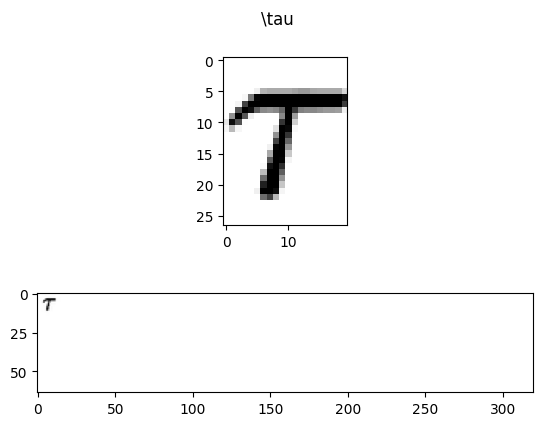

In [5]:
# Overlap example
overlap_example = list(train_inter)[random.randint(0, len(train_inter) - 1)]

overlap_index_wikipedia = wikipedia_latex["formula"].index(overlap_example)
overlap_index_100k = im2latex_100k["train"]["formula"].index(overlap_example)

# Plot figure with images from both datasets
fig = plt.figure()

plt.suptitle(overlap_example)

fig.add_subplot(2, 1, 1)
plt.imshow(wikipedia_latex[overlap_index_wikipedia]["image"])
    
fig.add_subplot(2, 1, 2)
plt.imshow(im2latex_100k["train"][overlap_index_100k]["image"])

## Building the Dataset

Build generators for wikipedia and 100k datasets, cropping the borders from each image for 100k and discarding duplicate cases.

In [6]:
# Initialize empty dataset, with a formula lookup set to maintain efficiency
loaded_formulas = set()

# Generator for final dataset
def im2latex_generator():
    
    # Function to crop white borders
    def crop_borders(img: PngImagePlugin.PngImageFile):
        return img.crop(ImageOps.invert(img.convert("RGB")).getbbox())
    
    # Function to ensure latex from both datasets is the same
    tokenization_regex = r'\\[a-zA-Z]+|(?<={)[a-zA-Z]+(?=})|[0-9]+|\S'
    def regularize_formula(text):
        regularized_text = ''.join([string + " " if string.startswith("\\") else string for string in text.split(" ")])
        tokens = re.findall(tokenization_regex, regularized_text)
        return " ".join(tokens)
    
    # Generator for wikipedia dataset
    # We prioritize this one as it tends to have higher quality images
    for expression in tqdm(wikipedia_latex):
        if not expression["formula"] in loaded_formulas:
            loaded_formulas.add(expression["formula"])
            yield {
                "formula": regularize_formula(expression["formula"]),
                "image": crop_borders(expression["image"])
            }
    
    # Generator for 100k dataset
    for set_name in im2latex_100k.keys():
        for expression in tqdm(im2latex_100k[set_name]):
            if not expression["formula"] in loaded_formulas:
                loaded_formulas.add(expression["formula"])
                yield {
                    "formula": regularize_formula(expression["formula"]),
                    "image": crop_borders(expression["image"])
                }

In [7]:
# Create dataset from generator
im2latex_dataset = Dataset.from_generator(im2latex_generator)

# Create an 8:1:1 training, validation, testing split
train_testvalid = im2latex_dataset.train_test_split(test_size=0.2, seed=32)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5, seed=64)
im2latex_dataset = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'val': test_valid['train']
})

# Verify final dataset size
print(im2latex_dataset['train'].num_rows)
print(im2latex_dataset['val'].num_rows)
print(im2latex_dataset['test'].num_rows)

print(f"final dataset size: {im2latex_dataset['train'].num_rows + im2latex_dataset['val'].num_rows + im2latex_dataset['test'].num_rows}")

100%|██████████| 6072/6072 [00:07<00:00, 770.51it/s]44 examples/s] 
Generating train split: 167450 examples [07:11, 388.20 examples/s]

133960
16745
16745
final dataset size: 167450


## Final Data Check Inspection and Saving

Check for final dataset for data leakage.
Save the dataset to `./data/im2latex-250k`.

In [8]:
# Convert formula lists to sets to compute intersection
final_train_set = set(im2latex_dataset["train"]["formula"])
final_val_set = set(im2latex_dataset["val"]["formula"])
final_test_set = set(im2latex_dataset["test"]["formula"])

train_inter = final_train_set.intersection(final_val_set)
print(f"the training set has {len(train_inter)} overlaps with the validation set")

val_inter = final_train_set.intersection(final_test_set)
print(f"the training set has {len(val_inter)} overlaps with the testing set")

test_inter = final_val_set.intersection(final_test_set)
print(f"the validation set {len(test_inter)} overlaps the testing set")

the training set has 0 overlaps with the validation set
the training set has 0 overlaps with the testing set
the validation set 0 overlaps the testing set


In [9]:
OUTPUT_DIR = "./data/im2latex-160k/"

# Save dataset to disk
im2latex_dataset.save_to_disk(OUTPUT_DIR)

Saving the dataset (1/1 shards): 100%|██████████| 16745/16745 [00:00<00:00, 73120.34 examples/s]


In [3]:
OUTPUT_DIR = "./data/im2latex-160k/"

# Load dataset to check if it has been saved correctly
loaded_im2latex_dataset = load_from_disk(OUTPUT_DIR)

print(loaded_im2latex_dataset)

DatasetDict({
    train: Dataset({
        features: ['formula', 'image'],
        num_rows: 133960
    })
    test: Dataset({
        features: ['formula', 'image'],
        num_rows: 16745
    })
    val: Dataset({
        features: ['formula', 'image'],
        num_rows: 16745
    })
})


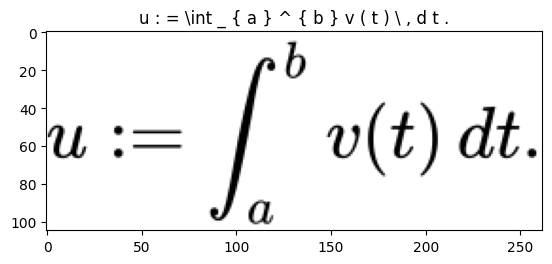

In [44]:
# Overlap example
random_index = random.randint(0, loaded_im2latex_dataset["train"].num_rows - 1)

# Plot formula
plt.title(loaded_im2latex_dataset["train"][random_index]["formula"])
plt.imshow(loaded_im2latex_dataset["train"][random_index]["image"])